<a href="https://colab.research.google.com/github/Meenusj/Case_study/blob/main/roberta_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch]
!pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = "/content/combined_mutation_results (1).csv"  # Replace with the actual path
df = pd.read_csv(file_path)

# Preprocess the text data
def preprocess_text(text):
    return text.lower()

mutation_columns = ['char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
                    'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

for col in mutation_columns:
    df[col] = df[col].apply(preprocess_text)

# Concatenate mutation columns into one
df['mutations_combined'] = df[mutation_columns].apply(lambda x: ' '.join(x), axis=1)

# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Shuffle the datasets
train_df = shuffle(train_df, random_state=42).reset_index(drop=True)
val_df = shuffle(val_df, random_state=42).reset_index(drop=True)
test_df = shuffle(test_df, random_state=42).reset_index(drop=True)

# Define file paths for saving the datasets
train_file = "train.csv"
val_file = "validation.csv"
test_file = "test.csv"

# Save the datasets to CSV files
train_df.to_csv(train_file, index=False)
val_df.to_csv(val_file, index=False)
test_df.to_csv(test_file, index=False)

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the text data
train_encodings = tokenizer(train_df['mutations_combined'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df['mutations_combined'].tolist(), truncation=True, padding=True, max_length=128)

# Convert labels to numerical format
label_mapping = {'human': 0, 'bot': 1, 'rnn': 1, 'gpt2': 1, 'others': 1}
train_labels = train_df['class_type'].map(label_mapping).tolist()
val_labels = val_df['class_type'].map(label_mapping).tolist()

# Create PyTorch datasets
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DetectionDataset(train_encodings, train_labels)
val_dataset = DetectionDataset(val_encodings, val_labels)

# Load the pre-trained RoBERTa model
roberta_base_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Define the training arguments for fine-tuning
training_args_finetune = TrainingArguments(
    output_dir="./roberta_finetuned_model",  # Adjust the output directory
    num_train_epochs=50,
    per_device_train_batch_size=32,  # Adjust batch size if needed
    per_device_eval_batch_size=32,    # Adjust batch size if needed
    logging_dir="./logs_finetune",
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    learning_rate=1e-4,
    load_best_model_at_end=True,
)
# Initialize the Trainer for fine-tuning
trainer_finetune = Trainer(
    model=roberta_base_model,
    args=training_args_finetune,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Assuming you already have val_dataset
    compute_metrics=lambda pred: {"accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1))},
)

# Train the model
trainer_finetune.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.468500,0.332514,0.843902
200,0.237500,0.595536,0.848780
300,0.117700,0.725703,0.882927
400,0.062100,0.690950,0.858537
500,0.029000,0.969581,0.853659
600,0.013500,1.072588,0.858537
700,0.012500,0.885567,0.863415
800,0.008900,0.824354,0.878049
900,0.022500,1.183323,0.853659
1000,0.020000,1.015620,0.858537


Step,Training Loss,Validation Loss,Accuracy
100,0.468500,0.332514,0.843902
200,0.237500,0.595536,0.848780
300,0.117700,0.725703,0.882927
400,0.062100,0.690950,0.858537
500,0.029000,0.969581,0.853659
600,0.013500,1.072588,0.858537
700,0.012500,0.885567,0.863415
800,0.008900,0.824354,0.878049
900,0.022500,1.183323,0.853659
1000,0.020000,1.015620,0.858537


TrainOutput(global_step=2900, training_loss=0.03427034119649887, metrics={'train_runtime': 2043.0621, 'train_samples_per_second': 45.055, 'train_steps_per_second': 1.419, 'total_flos': 6054843161472000.0, 'train_loss': 0.03427034119649887, 'epoch': 50.0})

In [2]:
import pandas as pd
test_df=pd.read_csv("/content/test.csv")

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score
from tabulate import tabulate

def evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation_column, label_mapping):
    # Tokenize the test data for the specified mutation
    test_encodings = tokenizer(test_df[mutation_column].tolist(), truncation=True, padding=True, max_length=128)

    # Create PyTorch dataset for the specified mutation
    test_labels = test_df['class_type'].map(label_mapping).tolist()
    test_dataset = DetectionDataset(test_encodings, test_labels)

    # Evaluate on the specified mutation test set
    predictions = trainer_finetune.predict(test_dataset)

    # Get predicted labels and probabilities
    predicted_labels = predictions.predictions.argmax(-1)
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

    # Calculate accuracy and AUC for the specified mutation
    accuracy = accuracy_score(test_labels, predicted_labels)
    auc = roc_auc_score(test_labels, probs[:, 1])

    return accuracy, auc

# Evaluate each mutation separately including original text
mutations = ['original_text', 'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
             'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

results = []
for mutation in mutations:
    mutation_accuracy, mutation_auc = evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation, label_mapping)
    if mutation == 'original_text':
        mutation = 'Human'
    results.append([mutation.capitalize(), mutation_accuracy, mutation_auc])

print("Roberta Finetune")
print(tabulate(results, headers=["Mutation", "Accuracy", "AUC"], tablefmt="fancy_grid"))


Roberta Finetune
╒═════════════════════════╤════════════╤══════════╕
│ Mutation                │   Accuracy │      AUC │
╞═════════════════════════╪════════════╪══════════╡
│ Human                   │   0.785156 │ 0.902723 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_article    │   0.804688 │ 0.902179 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adjective  │   0.791016 │ 0.903736 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adverb     │   0.791016 │ 0.903606 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_articles   │   0.785156 │ 0.889375 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adjectives │   0.787109 │ 0.90056  │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adverbs    │   0.787109 │ 0.900276 │
╘═════════════════════════╧════════════╧══════════╛


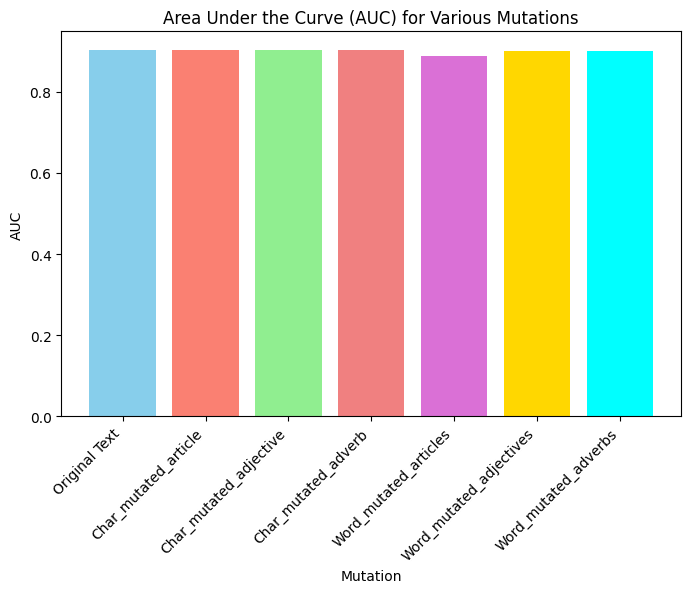

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation_column, label_mapping):
    # Tokenize the test data for the specified mutation
    test_encodings = tokenizer(test_df[mutation_column].tolist(), truncation=True, padding=True, max_length=128)

    # Create PyTorch dataset for the specified mutation
    test_labels = test_df['class_type'].map(label_mapping).tolist()
    test_dataset = DetectionDataset(test_encodings, test_labels)

    # Evaluate on the specified mutation test set
    predictions = trainer_finetune.predict(test_dataset)

    # Get predicted labels and probabilities
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

    # Calculate AUC for the specified mutation
    auc = roc_auc_score(test_labels, probs[:, 1])

    return auc

# Evaluate each mutation separately including original text
mutations = ['original_text', 'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
             'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

auc_scores = []
mutation_labels = []
for mutation in mutations:
    mutation_auc = evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation, label_mapping)
    auc_scores.append(mutation_auc)
    if mutation == 'original_text':
        mutation_labels.append('Original Text')
    else:
        mutation_labels.append(mutation.capitalize())

# Define colors for each mutation
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'orchid', 'gold', 'cyan']

# Plotting
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
plt.bar(np.arange(len(mutations)), auc_scores, color=colors)
plt.xlabel('Mutation')
plt.ylabel('AUC')
plt.title('Area Under the Curve (AUC) for Various Mutations')
plt.xticks(np.arange(len(mutations)), mutation_labels, rotation=45, ha='right')
plt.show()


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the source and destination paths
source_path = "./roberta_finetuned_model"  # Path to the folder you want to move
destination_path = "/content/drive/MyDrive/roberta_finetuned_model"  # Path in your Google Drive

# Move the folder to your Google Drive
!cp -r $source_path $destination_path


In [ ]:
import pandas as pd
test_df=pd.read_csv("/content/test (2).csv")

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Tokenize the original test data
test_original_encodings = tokenizer(test_df['original_text'].tolist(), truncation=True, padding=True, max_length=128)

# Create PyTorch dataset for original test data
test_original_labels = test_df['class_type'].map(label_mapping).tolist()
test_original_dataset = DetectionDataset(test_original_encodings, test_original_labels)

# Evaluate on the original test set
original_predictions = trainer_finetune.predict(test_original_dataset)

# Get predicted labels and probabilities
original_predicted_labels = original_predictions.predictions.argmax(-1)
original_probs = torch.nn.functional.softmax(torch.tensor(original_predictions.predictions), dim=-1)

# Calculate accuracy and AUC for original text
original_accuracy = accuracy_score(test_original_labels, original_predicted_labels)
original_auc = roc_auc_score(test_original_labels, original_probs[:, 1])

# Print accuracy and AUC for original text
print("Original Text:")
print(f"Accuracy: {original_accuracy}")
print(f"AUC: {original_auc}")


In [ ]:
# Tokenize the original test data for char_mutated_article mutation
test_char_mutated_article_encodings = tokenizer(test_df['char_mutated_article'].tolist(), truncation=True, padding=True, max_length=128)

# Create PyTorch dataset for char_mutated_article mutation
test_char_mutated_article_labels = test_df['class_type'].map(label_mapping).tolist()
test_char_mutated_article_dataset = DetectionDataset(test_char_mutated_article_encodings, test_char_mutated_article_labels)

# Evaluate on the char_mutated_article test set
char_mutated_article_predictions = trainer_finetune.predict(test_char_mutated_article_dataset)

# Get predicted labels and probabilities
char_mutated_article_predicted_labels = char_mutated_article_predictions.predictions.argmax(-1)
char_mutated_article_probs = torch.nn.functional.softmax(torch.tensor(char_mutated_article_predictions.predictions), dim=-1)

# Calculate accuracy and AUC for char_mutated_article mutation
char_mutated_article_accuracy = accuracy_score(test_char_mutated_article_labels, char_mutated_article_predicted_labels)
char_mutated_article_auc = roc_auc_score(test_char_mutated_article_labels, char_mutated_article_probs[:, 1])

# Print accuracy and AUC for char_mutated_article mutation
print("Char Mutated Article Mutation:")
print(f"Accuracy: {char_mutated_article_accuracy}")
print(f"AUC: {char_mutated_article_auc}")


In [ ]:
from sklearn.metrics import roc_curve

# Calculate ROC curve for char_mutated_article mutation
fpr_char_mutated_article, tpr_char_mutated_article, _ = roc_curve(test_char_mutated_article_labels, char_mutated_article_probs[:, 1])

import matplotlib.pyplot as plt

# Plot AUC for char_mutated_article mutation
plt.figure(figsize=(8, 6))
plt.plot(fpr_char_mutated_article, tpr_char_mutated_article, label='char_mutated_article Mutation (AUC = %0.2f)' % char_mutated_article_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - char_mutated_article Mutation')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Tokenize the original test data for char_mutated_adjective mutation
test_char_mutated_adjective_encodings = tokenizer(test_df['char_mutated_adjective'].tolist(), truncation=True, padding=True, max_length=128)

# Create PyTorch dataset for char_mutated_adjective mutation
test_char_mutated_adjective_labels = test_df['class_type'].map(label_mapping).tolist()
test_char_mutated_adjective_dataset = DetectionDataset(test_char_mutated_adjective_encodings, test_char_mutated_adjective_labels)

# Evaluate on the char_mutated_adjective test set
char_mutated_adjective_predictions = trainer_finetune.predict(test_char_mutated_adjective_dataset)

# Get predicted labels and probabilities
char_mutated_adjective_predicted_labels = char_mutated_adjective_predictions.predictions.argmax(-1)
char_mutated_adjective_probs = torch.nn.functional.softmax(torch.tensor(char_mutated_adjective_predictions.predictions), dim=-1)

# Calculate accuracy and AUC for char_mutated_adjective mutation
char_mutated_adjective_accuracy = accuracy_score(test_char_mutated_adjective_labels, char_mutated_adjective_predicted_labels)
char_mutated_adjective_auc = roc_auc_score(test_char_mutated_adjective_labels, char_mutated_adjective_probs[:, 1])

# Print accuracy and AUC for char_mutated_adjective mutation
print("Char Mutated Adjective Mutation:")
print(f"Accuracy: {char_mutated_adjective_accuracy}")
print(f"AUC: {char_mutated_adjective_auc}")


In [ ]:
# Tokenize the original test data for char_mutated_adverb mutation
test_char_mutated_adverb_encodings = tokenizer(test_df['char_mutated_adverb'].tolist(), truncation=True, padding=True, max_length=128)

# Create PyTorch dataset for char_mutated_adverb mutation
test_char_mutated_adverb_labels = test_df['class_type'].map(label_mapping).tolist()
test_char_mutated_adverb_dataset = DetectionDataset(test_char_mutated_adverb_encodings, test_char_mutated_adverb_labels)

# Evaluate on the char_mutated_adverb test set
char_mutated_adverb_predictions = trainer_finetune.predict(test_char_mutated_adverb_dataset)

# Get predicted labels and probabilities
char_mutated_adverb_predicted_labels = char_mutated_adverb_predictions.predictions.argmax(-1)
char_mutated_adverb_probs = torch.nn.functional.softmax(torch.tensor(char_mutated_adverb_predictions.predictions), dim=-1)

# Calculate accuracy and AUC for char_mutated_adverb mutation
char_mutated_adverb_accuracy = accuracy_score(test_char_mutated_adverb_labels, char_mutated_adverb_predicted_labels)
char_mutated_adverb_auc = roc_auc_score(test_char_mutated_adverb_labels, char_mutated_adverb_probs[:, 1])

# Print accuracy and AUC for char_mutated_adverb mutation
print("Char Mutated Adverb Mutation:")
print(f"Accuracy: {char_mutated_adverb_accuracy}")
print(f"AUC: {char_mutated_adverb_auc}")


In [ ]:
# Tokenize the original test data for word_mutated_articles mutation
test_word_mutated_articles_encodings = tokenizer(test_df['word_mutated_articles'].tolist(), truncation=True, padding=True, max_length=128)

# Create PyTorch dataset for word_mutated_articles mutation
test_word_mutated_articles_labels = test_df['class_type'].map(label_mapping).tolist()
test_word_mutated_articles_dataset = DetectionDataset(test_word_mutated_articles_encodings, test_word_mutated_articles_labels)

# Evaluate on the word_mutated_articles test set
word_mutated_articles_predictions = trainer_finetune.predict(test_word_mutated_articles_dataset)

# Get predicted labels and probabilities
word_mutated_articles_predicted_labels = word_mutated_articles_predictions.predictions.argmax(-1)
word_mutated_articles_probs = torch.nn.functional.softmax(torch.tensor(word_mutated_articles_predictions.predictions), dim=-1)

# Calculate accuracy and AUC for word_mutated_articles mutation
word_mutated_articles_accuracy = accuracy_score(test_word_mutated_articles_labels, word_mutated_articles_predicted_labels)
word_mutated_articles_auc = roc_auc_score(test_word_mutated_articles_labels, word_mutated_articles_probs[:, 1])

# Print accuracy and AUC for word_mutated_articles mutation
print("Word Mutated Articles Mutation:")
print(f"Accuracy: {word_mutated_articles_accuracy}")
print(f"AUC: {word_mutated_articles_auc}")

# Repeat the process for word_mutated_adjectives mutation
test_word_mutated_adjectives_encodings = tokenizer(test_df['word_mutated_adjectives'].tolist(), truncation=True, padding=True, max_length=128)
test_word_mutated_adjectives_labels = test_df['class_type'].map(label_mapping).tolist()
test_word_mutated_adjectives_dataset = DetectionDataset(test_word_mutated_adjectives_encodings, test_word_mutated_adjectives_labels)
word_mutated_adjectives_predictions = trainer_finetune.predict(test_word_mutated_adjectives_dataset)
word_mutated_adjectives_predicted_labels = word_mutated_adjectives_predictions.predictions.argmax(-1)
word_mutated_adjectives_probs = torch.nn.functional.softmax(torch.tensor(word_mutated_adjectives_predictions.predictions), dim=-1)
word_mutated_adjectives_accuracy = accuracy_score(test_word_mutated_adjectives_labels, word_mutated_adjectives_predicted_labels)
word_mutated_adjectives_auc = roc_auc_score(test_word_mutated_adjectives_labels, word_mutated_adjectives_probs[:, 1])

print("Word Mutated Adjectives Mutation:")
print(f"Accuracy: {word_mutated_adjectives_accuracy}")
print(f"AUC: {word_mutated_adjectives_auc}")

# Repeat the process for word_mutated_adverbs mutation
test_word_mutated_adverbs_encodings = tokenizer(test_df['word_mutated_adverbs'].tolist(), truncation=True, padding=True, max_length=128)
test_word_mutated_adverbs_labels = test_df['class_type'].map(label_mapping).tolist()
test_word_mutated_adverbs_dataset = DetectionDataset(test_word_mutated_adverbs_encodings, test_word_mutated_adverbs_labels)
word_mutated_adverbs_predictions = trainer_finetune.predict(test_word_mutated_adverbs_dataset)
word_mutated_adverbs_predicted_labels = word_mutated_adverbs_predictions.predictions.argmax(-1)
word_mutated_adverbs_probs = torch.nn.functional.softmax(torch.tensor(word_mutated_adverbs_predictions.predictions), dim=-1)
word_mutated_adverbs_accuracy = accuracy_score(test_word_mutated_adverbs_labels, word_mutated_adverbs_predicted_labels)
word_mutated_adverbs_auc = roc_auc_score(test_word_mutated_adverbs_labels, word_mutated_adverbs_probs[:, 1])

print("Word Mutated Adverbs Mutation:")
print(f"Accuracy: {word_mutated_adverbs_accuracy}")
print(f"AUC: {word_mutated_adverbs_auc}")



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute FPR and TPR for each mutation type
fpr_char_mutated_article, tpr_char_mutated_article, _ = roc_curve(test_char_mutated_article_labels, char_mutated_article_probs[:, 1])
fpr_char_mutated_adjective, tpr_char_mutated_adjective, _ = roc_curve(test_char_mutated_adjective_labels, char_mutated_adjective_probs[:, 1])
fpr_char_mutated_adverb, tpr_char_mutated_adverb, _ = roc_curve(test_char_mutated_adverb_labels, char_mutated_adverb_probs[:, 1])
fpr_word_mutated_articles, tpr_word_mutated_articles, _ = roc_curve(test_word_mutated_articles_labels, word_mutated_articles_probs[:, 1])
fpr_word_mutated_adjectives, tpr_word_mutated_adjectives, _ = roc_curve(test_word_mutated_adjectives_labels, word_mutated_adjectives_probs[:, 1])
fpr_word_mutated_adverbs, tpr_word_mutated_adverbs, _ = roc_curve(test_word_mutated_adverbs_labels, word_mutated_adverbs_probs[:, 1])

# Plot ROC curves for each mutation type
plt.figure(figsize=(10, 8))

plt.plot(fpr_char_mutated_article, tpr_char_mutated_article, label='char_mutated_article')
plt.plot(fpr_char_mutated_adjective, tpr_char_mutated_adjective, label='char_mutated_adjective')
plt.plot(fpr_char_mutated_adverb, tpr_char_mutated_adverb, label='char_mutated_adverb')
plt.plot(fpr_word_mutated_articles, tpr_word_mutated_articles, label='word_mutated_articles')
plt.plot(fpr_word_mutated_adjectives, tpr_word_mutated_adjectives, label='word_mutated_adjectives')
plt.plot(fpr_word_mutated_adverbs, tpr_word_mutated_adverbs, label='word_mutated_adverbs')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Mutations')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Define mutation names and AUC scores
mutation_names = ['char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
                  'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']
auc_scores = [char_mutated_article_auc, char_mutated_adjective_auc, char_mutated_adverb_auc,
              word_mutated_articles_auc, word_mutated_adjectives_auc, word_mutated_adverbs_auc]

# Plot AUC scores
plt.figure(figsize=(10, 6))
plt.bar(mutation_names, auc_scores, color='skyblue')
plt.xlabel('Mutation Type')
plt.ylabel('Area Under Curve (AUC)')
plt.title('AUC for Different Mutations')
plt.ylim(0, 1)  # Set y-axis limit
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
